In [34]:
import torch
import matplotlib.pyplot as plt
import sys
import numpy as np
import neuralop
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.training import OutputEncoderCallback
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss
import importlib

device = 'cpu'

In [35]:
from neuralop.layers.quad_prod import *

In [36]:
importlib.reload(neuralop.layers.quad_prod)

<module 'neuralop.layers.quad_prod' from '/home/yichen/repo/cfd/myNeuralOperator/neuralop/layers/quad_prod.py'>

In [28]:
# 假设的输入张量和门控系数
# input_tensor 的形状为 [batch_size, channel_dim, ...]
# gating_coefficient 的形状为 [channel_dim]
input_tensor = torch.tensor(np.array([[1 ,1, 4], [5, 1, 4]]))  # 您的输入张量
gating_coefficient = 0.5 * torch.ones([1,3])

# 改变门控系数的形状以匹配输入张量的通道维度
# gating_coefficient.unsqueeze_(0)

# 通过广播执行元素乘法
output_tensor = input_tensor * gating_coefficient


In [29]:
output_tensor

tensor([[[0.5000, 0.5000, 2.0000],
         [2.5000, 0.5000, 2.0000]]])

In [20]:
a = torch.tensor(np.array([1 ,1, 4]))
b = torch.tensor(np.array([5 ,1, 4]))
func = torch.add

In [38]:
d = torch.exp(-1j * 2 * np.pi * a).to('cuda')

In [19]:
a.clamp_(0, 3)
a

tensor([1, 1, 3])

In [5]:
func(a,b)

tensor([6, 2, 8])

In [16]:
idxs = torch.range(0, 10, 1, dtype=torch.int)

/tmp/ipykernel_77327/3986098922.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  idxs = torch.range(0, 10, 1, dtype=torch.int)


In [17]:
a[idxs[0]]

tensor(1)

In [10]:
c = torch.cat([a.unsqueeze(-1), b.unsqueeze(-1)], dim=-1)
c

tensor([[1, 5],
        [1, 1],
        [4, 4]])

In [11]:
func(c, c)

tensor([[ 2, 10],
        [ 2,  2],
        [ 8,  8]])

In [1]:
class fucker:
    def __init__(self, dumb=True):
        if dumb:
            self.fuck = lambda a: a
        else:
            self.fuck = lambda a: -a

In [2]:
me = fucker(dumb=False)
you = fucker(dumb=True)

print(me.fuck(1), you.fuck(1))

-1 1


In [2]:
import torch
torch.cuda.is_available()

/home/yichen/anaconda3/envs/test/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [2]:
# class base_test:
#     def __init__(self, a, b, c):
#         self.a = a
#         self.b = b
#         self.c = c
    
#     def f(self, x):
#         pass

# class class_test(base_test):
#     def __init__(self, a, b, c, **kargs):
#         super().__init__(a, b, c)
#         self.d = kargs['d']
#         self.e = kargs['e']
#         def f(x):
#             return x + self.b
#         self.f = f

# test = class_test(d=3, e=4, a=0, b=1, c=2)

# test.f(1)
# # for name in test.__dict__:
# #     print(name, getattr(test, name))

In [3]:
# Loading the Navier-Stokes dataset in 128x128 resolution
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32


In [4]:
# We create a tensorized FNO model

model = TFNO(in_dim=5, n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 402785 parameters.


In [5]:
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-7): 8 x ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.trainin

In [6]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  callbacks=[OutputEncoderCallback(output_encoder)],             
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


In [9]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size

KeyboardInterrupt: 

/tmp/ipykernel_36960/1837442807.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


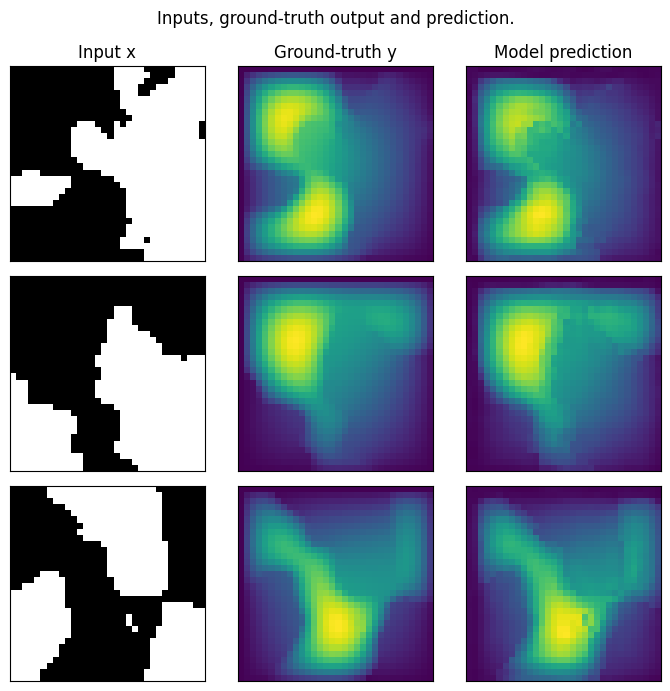

In [12]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

/tmp/ipykernel_36960/1355466477.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


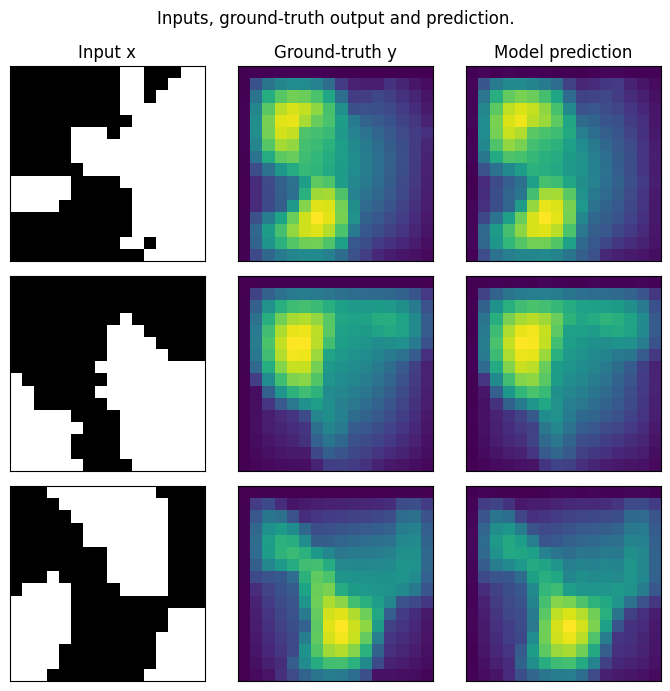

In [13]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()